In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
plt.style.use('ggplot')

Data are available in the MOOC repository. The CSV file contains data for the 1314 women that were polled in Whickham, England, in 1972-1974 and were categorized as "currently smoking" or "never smoked". Each line is related to a person and contains whether she smokes or not, whether alive or dead twenty year after the survey and her age at the time of the survey.

In [2]:
data_url = "https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/-/raw/master/module3/Practical_session/Subject6_smoking.csv"
data = pd.read_csv(data_url)
print("Number of rows:", len(data))
data.head()

Number of rows: 1314


Smoker Status   Age
0    Yes  Alive  21.0
1    Yes  Alive  19.3
2     No   Dead  57.5
3     No  Alive  47.1
4    Yes  Alive  81.4

The CSV file does not contain any missing data.

In [3]:
print("Number of rows with missing values:", data.isnull().any(axis=1).sum())

Number of rows with missing values: 0


---

Let's visualize the number of women alive and dead after twenty years, according to their smoking habits. A heatmap is effective in this case.

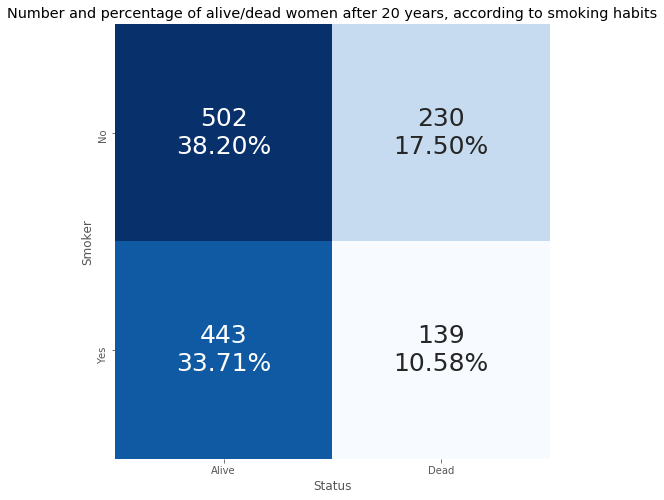

In [4]:
count = np.array(data.groupby(['Smoker', 'Status']).count())
count = np.reshape(count, (2, 2))
annots = np.array([f"{v}\n{v/len(data):.2%}" for v in count.flatten()]).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(count, annot=annots, fmt="", cmap='Blues', cbar=False, square=True,
           xticklabels=['Alive', 'Dead'], yticklabels=['No', 'Yes'], annot_kws={"fontsize": 25})
plt.title("Number and percentage of alive/dead women after 20 years, according to smoking habits")
plt.xlabel("Status")
plt.ylabel("Smoker")
plt.show()

It is possible to see that the fraction of smokers and non smokers is quite balanced (in total, 582 smokers and 732 non smokers). As expected, there are less dead than alive people (369 versus 945).

We can then compute the mortality rate for the two groups. For a population proportion $p$, confidence intervals are computed as $\hat{p} \pm z \cdot \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the sample proportion, $n$ is the sample size and $z$ is the value derived from the standard normal distribution. For 95% confidence intervals, $z=1.96$.

In [5]:
z = 1.96

num_smokers = sum(data['Smoker'] == "Yes")
num_dead_smokers = sum(np.logical_and(data['Smoker'] == "Yes", data['Status'] == "Dead"))
rate_smokers = num_dead_smokers / num_smokers
ci_smokers = z * (rate_smokers * (1 - rate_smokers) / num_smokers) ** 0.5
print(f"Mortality rate for smokers:\t{rate_smokers:.2%} " + u"\u00B1" + f" {ci_smokers:.2%}")

num_non_smokers = len(data) - num_smokers
num_dead_non_smokers = sum(np.logical_and(data['Smoker'] == "No", data['Status'] == "Dead"))
rate_non_smokers = num_dead_non_smokers / num_non_smokers
ci_non_smokers = z * (rate_non_smokers * (1 - rate_non_smokers) / num_non_smokers) ** 0.5
print(f"Mortality rate for non smokers:\t{rate_non_smokers:.2%} " + u"\u00B1" + f" {ci_non_smokers:.2%}")

Mortality rate for smokers:	23.88% ± 3.46%
Mortality rate for non smokers:	31.42% ± 3.36%


Surprisingly, the mortality rate is sensibly higher for women categorized as non smokers. However, we are not taking into account an important information: the age of those people at the time of the poll. This result can be expected, for example, if the average age of polled non smokers was higher than the one of smokers, leading them to earlier death independently from their smoking habits.

---

Let's now include the age in the analysis. The following age classes are considered: 18-34 years, 35-54 years, 55-64 years, over 65 years.

In [6]:
def bin_age(age):
    if age < 18:
        return None
    if age < 35:
        return "18-34 years"
    elif age < 55:
        return "35-54 years"
    elif age < 65:
        return "55-64 years"
    else:
        return "Over 65 years"

data['Age group'] = data['Age'].apply(bin_age)
data.head()

Smoker Status   Age      Age group
0    Yes  Alive  21.0    18-34 years
1    Yes  Alive  19.3    18-34 years
2     No   Dead  57.5    55-64 years
3     No  Alive  47.1    35-54 years
4    Yes  Alive  81.4  Over 65 years

Again, let's check that no missing data are present, to ensure that no women under 18 was polled.

In [7]:
print("Number of rows with missing values:", data.isnull().any(axis=1).sum())

Number of rows with missing values: 0


Let's visualize the number on women alive and dead after twenty years, according to their smoking habits and age. Different colors correspond to different couples of smoking habits and status.

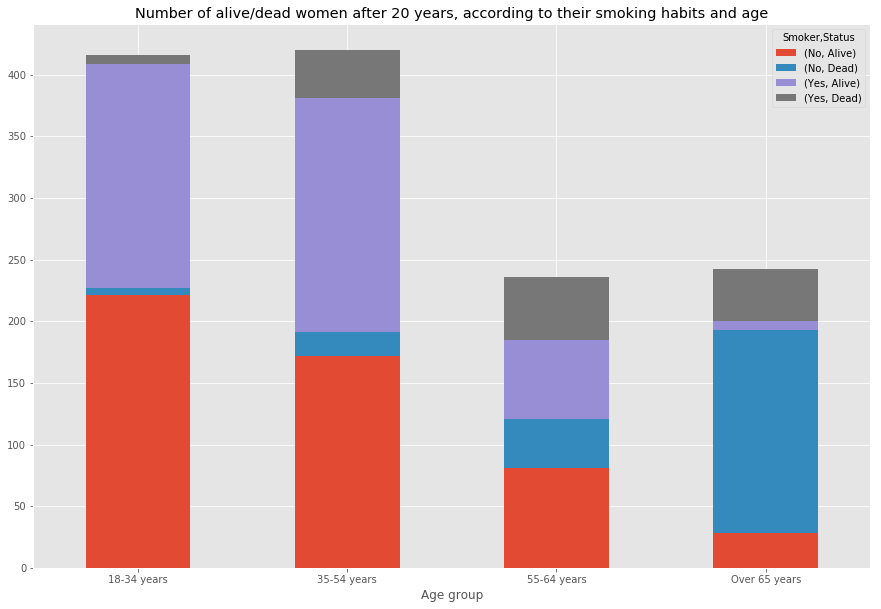

In [8]:
_, ax = plt.subplots(figsize=(15, 10))
data.pivot_table(index=['Age group'], columns=['Smoker', 'Status'], aggfunc='size').plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Number of alive/dead women after 20 years, according to their smoking habits and age")
ax.tick_params(axis="x", rotation=0)
plt.show()

One can see that most women that were over 65 in 1972 are dead twenty years after and that at the time of the survey a great majority of polled older women were non-smokers. For the other age groups results look similar but are difficult to interpret.

Let's therefore compute the mortality rates for smokers and non-smokers in different age groups.

In [9]:
def ci_per_age(age_group):
    pop = data[data['Age group'] == group]
    print(f"Age group: {group}")
    
    num_smokers = sum(pop['Smoker'] == "Yes")
    num_dead_smokers = sum(np.logical_and(pop['Smoker'] == "Yes", pop['Status'] == "Dead"))
    rate_smokers = num_dead_smokers / num_smokers
    ci_smokers = z * (rate_smokers * (1 - rate_smokers) / num_smokers) ** 0.5
    print(f"\tMortality rate for smokers:\t{rate_smokers:.2%} " + u"\u00B1" + f" {ci_smokers:.2%}")

    num_non_smokers = len(pop) - num_smokers
    num_dead_non_smokers = sum(np.logical_and(pop['Smoker'] == "No", pop['Status'] == "Dead"))
    rate_non_smokers = num_dead_non_smokers / num_non_smokers
    ci_non_smokers = z * (rate_non_smokers * (1 - rate_non_smokers) / num_non_smokers) ** 0.5
    print(f"\tMortality rate for non smokers:\t{rate_non_smokers:.2%} " + u"\u00B1" + f" {ci_non_smokers:.2%}")
    
for group in sorted(data['Age group'].unique()):
    ci_per_age(group)
    print()

Age group: 18-34 years
	Mortality rate for smokers:	3.70% ± 2.69%
	Mortality rate for non smokers:	2.64% ± 2.09%

Age group: 35-54 years
	Mortality rate for smokers:	17.03% ± 4.87%
	Mortality rate for non smokers:	9.95% ± 4.24%

Age group: 55-64 years
	Mortality rate for smokers:	44.35% ± 9.08%
	Mortality rate for non smokers:	33.06% ± 8.38%

Age group: Over 65 years
	Mortality rate for smokers:	85.71% ± 9.80%
	Mortality rate for non smokers:	85.49% ± 4.97%



Now, the mortality rate is considerably higher for smokers, especially for people between 35 and 65 years old. This might seem like a contradiction, as before the rate was higher for non-smokers. However, from the previous bar chart it is clear that the percentage of polled smokers/non-smokers is different in different age groups, in particular for older women as mentioned. In addition, the fact that most polled women over 65 are non-smokers can be an argument in favor of the hypothesis that smoking is dangerous for health, but this can't be proven through statistics.

---

The age groups are fixed a-priori. In order to have more flexible results and reduce the introduced bias, it is possible to try to perform a logistic regression, studying the probability of death in the two groups according to the age. A column of 1 is also added as intercept for the model.

In [10]:
death = []
for status in data['Status']:
    if status == "Alive":
        death.append(0)
    elif status == "Dead":
        death.append(1)
assert len(death) == len(data['Age'])
data['Death'] = death
data['Intercept'] = 1
data.head()

Smoker Status   Age      Age group  Death  Intercept
0    Yes  Alive  21.0    18-34 years      0          1
1    Yes  Alive  19.3    18-34 years      0          1
2     No   Dead  57.5    55-64 years      1          1
3     No  Alive  47.1    35-54 years      0          1
4    Yes  Alive  81.4  Over 65 years      0          1

In [11]:
smokers = data[data['Smoker'] == "Yes"]
log_smokers = sm.Logit(smokers[['Death']], smokers[['Intercept', 'Age']]).fit()
print(log_smokers.summary())

Optimization terminated successfully.
         Current function value: 0.412727
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Dec 2021   Pseudo R-squ.:                  0.2492
Time:                        18:06:08   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
                                        LLR p-value:                 1.477e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5081      0.466    -11.814      0.000      -6.422      -4.594
Age            0.0890      0.

In [12]:
non_smokers = data[data['Smoker'] == "No"]
log_non_smokers = sm.Logit(non_smokers[['Death']], non_smokers[['Intercept', 'Age']]).fit()
print(log_non_smokers.summary())

Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  732
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Dec 2021   Pseudo R-squ.:                  0.4304
Time:                        18:06:08   Log-Likelihood:                -259.54
converged:                       True   LL-Null:                       -455.62
                                        LLR p-value:                 2.808e-87
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7955      0.479    -14.174      0.000      -7.735      -5.856
Age            0.1073      0.

In both fitted models, the p value (`P>|z|` in *statsmodels*) for the hypothesis that age does not have any impact on death probability is 0. The hypothesis is therefore discarded (as one might have imagined) and age and intercept are taken into account for the analysis.

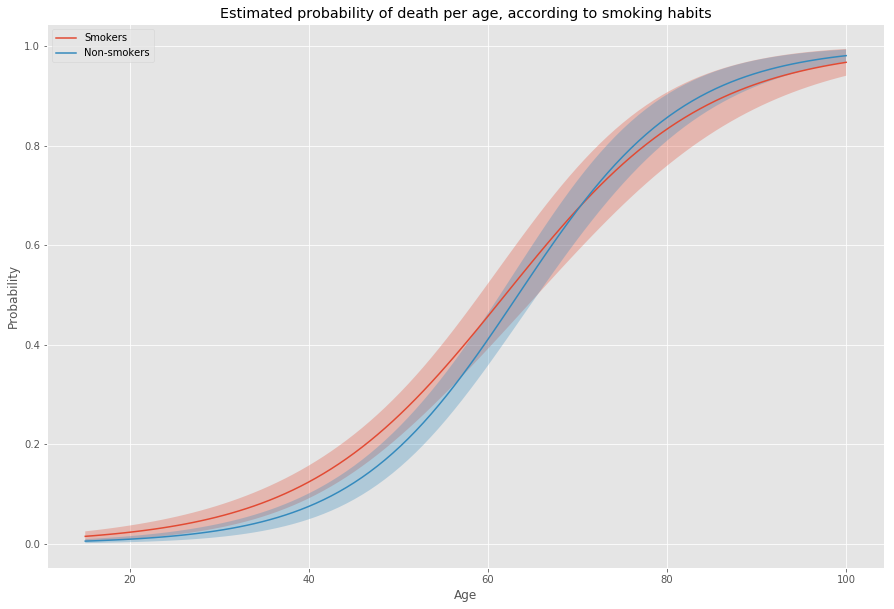

In [13]:
def plot_pred_confidence_intervals(model, X, xlabel, label=None):
    # https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
    preds = model.predict(X)
    
    cov = model.cov_params()
    gradient = np.array((preds * (1 - preds) * X.T).T)
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    upper = np.maximum(0, np.minimum(1, preds + std_errors * z))
    lower = np.maximum(0, np.minimum(1, preds - std_errors * z))
    
    plt.plot(X[xlabel], preds, label=label)
    plt.fill_between(X[xlabel], lower, upper, alpha=0.3)
    

plt.figure(figsize=(15, 10))
data_pred = pd.DataFrame({'Age': np.linspace(start=15, stop=100, num=100), 'Intercept': 1})

plot_pred_confidence_intervals(log_smokers, data_pred[['Intercept', 'Age']], 'Age', label="Smokers")
plot_pred_confidence_intervals(log_non_smokers, data_pred[['Intercept', 'Age']], 'Age', label="Non-smokers")

plt.title("Estimated probability of death per age, according to smoking habits")
plt.xlabel("Age")
plt.ylabel("Probability")
plt.legend()
plt.show()

From the previous plot, we can conclude with a good confidence that the death probability is lower for non-smokers up to the age of 45/50. From this point, the confidence interval for non-smokers become wider (due to the lower number of women smokers over 65 years of age as highlighted earlier) and predicted probabilities cross around the age of 70. Estimated death probability becomes higher for non-smokers, but results are difficult to interpret and it is not possible to draw any clear conclusion about the impact of smoking on life expectancy.

We can then try to compare the obtained curve with the predictions produced by *scikit-learn*, probably the most popular Python library for machine learning. Differently from *statsmodels*, *scikit-learn* does not allow to derive prediction confidence intervals and uses regularization by default.

In [14]:
sklog_smokers = LogisticRegression().fit(smokers['Age'].values.reshape([-1, 1]), smokers['Death'])
sklog_non_smokers = LogisticRegression().fit(non_smokers['Age'].values.reshape([-1, 1]), non_smokers['Death'])

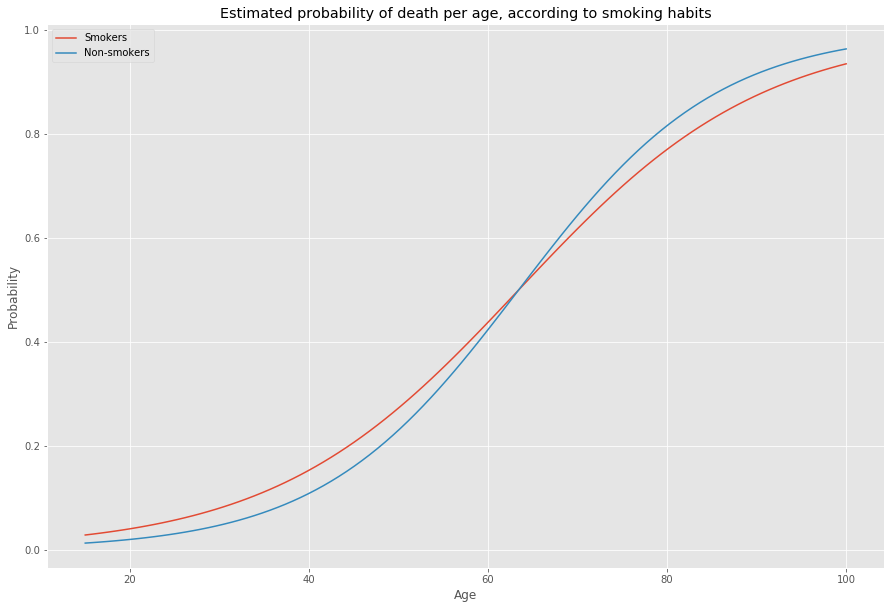

In [15]:
plt.figure(figsize=(15, 10))
data_pred = np.linspace(start=15, stop=100, num=100)

smoker_proba = sklog_smokers.predict_proba(data_pred.reshape([-1, 1]))
plt.plot(data_pred, smoker_proba[:, 1], label="Smokers")

non_smoker_proba = sklog_non_smokers.predict_proba(data_pred.reshape([-1, 1]))
plt.plot(data_pred, non_smoker_proba[:, 1], label="Non-smokers")

plt.title("Estimated probability of death per age, according to smoking habits")
plt.xlabel("Age")
plt.ylabel("Probability")
plt.legend()
plt.show()

For *scikit-learn*, the plot of estimated probabilities cross earlier than for *statsmodels*. The lack of confidence intervals makes results non-interpretable.